This notebook generates figures illustrating the bias analysis of the multi-step prediction rollout, as described in Supplementary Material Section 9.

In [1]:
import random
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from allen_cahn_equation import (
    compute_exact_solution_random_ic_vary_Nx, 
    plot_both_grids
)
from data_processing import (
    SimpleSerializerSettings, 
    scale_2d_array, 
    unscale_2d_array,
    serialize_2d_integers, 
    deserialize_2d_integers
)

# Set random seeds for reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

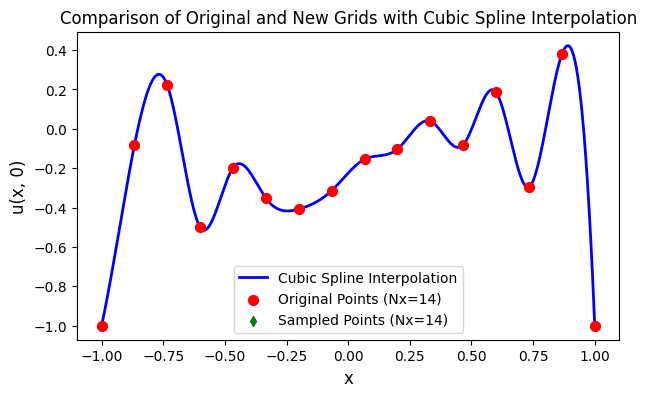

In [2]:
# Define parameters for the Allen-Cahn equation
L = 2       # Length of the spatial domain
k = 0.001   # Thermal diffusivity
T = 0.5     # Total simulation time
Nt = 25     # Number of time steps
dt = T/Nt
Nx = 14     # Number of spatial steps (excluding boundary points)
dx = L/(Nx+1)

# Generate random initial conditions and setup grids
init_cond_random = np.random.uniform(-0.5, 0.5, size=Nx)
Nx_new = 14
fig, cs, _ = plot_both_grids(L, Nx, Nx_new, init_cond_random)
settings = SimpleSerializerSettings(space_sep=",", time_sep=";")
input_time_steps = 16
number_of_future_predictions = 10
# Compute exact solution
u_exact = compute_exact_solution_random_ic_vary_Nx(L, k, T, Nx, Nt, spline_obj=cs)
u_exact_scaled, vmin_exact, vmax_exact = scale_2d_array(u_exact)
u_exact_serialized = serialize_2d_integers(u_exact_scaled, settings)
u_exact_parsed = deserialize_2d_integers(u_exact_serialized, settings)
u_exact_unscaled = unscale_2d_array(u_exact_parsed, vmin_exact, vmax_exact)
# Compute time-dependent quant floors
baseline_max_errors_per_step = []
baseline_rmse_errors_per_step = []
for t in range(u_exact.shape[0]):
    max_err_t = np.max(np.abs(u_exact[t, :] - u_exact_unscaled[t, :]))
    rmse_err_t = np.sqrt(np.mean((u_exact[t, :] - u_exact_unscaled[t, :])**2))
    baseline_max_errors_per_step.append(max_err_t)
    baseline_rmse_errors_per_step.append(rmse_err_t)

baseline_max_errors_per_step = np.array(baseline_max_errors_per_step)
baseline_rmse_errors_per_step = np.array(baseline_rmse_errors_per_step)
baseline_max_errors_prediction = baseline_max_errors_per_step[16:]
baseline_rmse_errors_prediction = baseline_rmse_errors_per_step[16:]
n_seeds = 20
t_critical = stats.t.ppf(0.975, n_seeds - 1)  # 95% CI

In [3]:
# Load Llama-3.1-8B model data
with np.load("8B_10_step.npz", allow_pickle=True) as data_8b:
    llm_max_diffs = np.array(data_8b["llm_max_diffs_8B"])
    llm_rmses = np.array(data_8b["llm_rmses_8B"])
    llm_predictions = np.array(data_8b["llm_predictions_8B"])
    std_max_diffs = np.array(data_8b["std_max_diffs_8B"])
    std_rmses = np.array(data_8b["std_rmses_8B"])
    fd_results = np.array(data_8b["fd_results"]).item()

# Load Llama-3.2-3B model data
with np.load("3B_10_step.npz", allow_pickle=True) as data_3b:
    llm_max_diffs_3B = np.array(data_3b["llm_max_diffs_3B"])
    llm_rmses_3B = np.array(data_3b["llm_rmses_3B"])
    llm_predictions_3B = np.array(data_3b["llm_predictions_3B"])
    std_max_diffs_3B = np.array(data_3b["std_max_diffs_3B"])
    std_rmses_3B = np.array(data_3b["std_rmses_3B"])

# Load Llama-3.2-1B model data
with np.load("1B_10_step.npz", allow_pickle=True) as data_1b:
    llm_max_diffs_1B = np.array(data_1b["llm_max_diffs_1B"])
    llm_rmses_1B = np.array(data_1b["llm_rmses_1B"])
    llm_predictions_1B = np.array(data_1b["llm_predictions_1B"])
    std_max_diffs_1B = np.array(data_1b["std_max_diffs_1B"])
    std_rmses_1B = np.array(data_1b["std_rmses_1B"])

ftcs_max_diff = fd_results['ftcs']['max_diff']
ftcs_rmse = fd_results['ftcs']['rmse']
ftcs_predictions = fd_results['ftcs']['predictions']
imex_max_diff = fd_results['imex']['max_diff']
imex_rmse = fd_results['imex']['rmse']
imex_predictions = fd_results['imex']['predictions']


def log_ci(mean, std, n, tcrit):
    """
    95% CI for log10 axis
    mean : arithmetic mean of the n samples
    std : sample std of the n samples
    n : number of samples
    tcrit: two-sided t critical value
    """
    se = std / np.sqrt(n)  # SE in linear space
    se_log = se / (mean * np.log(10))  # delta-method SE in log space
    mean_log = np.log10(mean)
    delta_log = tcrit * se_log
    return 10**(mean_log - delta_log), 10**(mean_log + delta_log)


# 95% CIs for Llama-3.1-8B
ci_lower_max_diffs = []
ci_upper_max_diffs = []
ci_lower_rmses = []
ci_upper_rmses = []
for mean, std in zip(llm_max_diffs, std_max_diffs):
    lower, upper = log_ci(mean, std, n_seeds, t_critical)
    ci_lower_max_diffs.append(lower)
    ci_upper_max_diffs.append(upper)
for mean, std in zip(llm_rmses, std_rmses):
    lower, upper = log_ci(mean, std, n_seeds, t_critical)
    ci_lower_rmses.append(lower)
    ci_upper_rmses.append(upper)

# 95% CIs for Llama-3.2-3B
ci_lower_max_diffs_3B = []
ci_upper_max_diffs_3B = []
ci_lower_rmses_3B = []
ci_upper_rmses_3B = []
for mean, std in zip(llm_max_diffs_3B, std_max_diffs_3B):
    lower, upper = log_ci(mean, std, n_seeds, t_critical)
    ci_lower_max_diffs_3B.append(lower)
    ci_upper_max_diffs_3B.append(upper)
for mean, std in zip(llm_rmses_3B, std_rmses_3B):
    lower, upper = log_ci(mean, std, n_seeds, t_critical)
    ci_lower_rmses_3B.append(lower)
    ci_upper_rmses_3B.append(upper)

# 95% CIs for Llama-3.2-1B
ci_lower_max_diffs_1B = []
ci_upper_max_diffs_1B = []
ci_lower_rmses_1B = []
ci_upper_rmses_1B = []
for mean, std in zip(llm_max_diffs_1B, std_max_diffs_1B):
    lower, upper = log_ci(mean, std, n_seeds, t_critical)
    ci_lower_max_diffs_1B.append(lower)
    ci_upper_max_diffs_1B.append(upper)
for mean, std in zip(llm_rmses_1B, std_rmses_1B):
    lower, upper = log_ci(mean, std, n_seeds, t_critical)
    ci_lower_rmses_1B.append(lower)
    ci_upper_rmses_1B.append(upper)

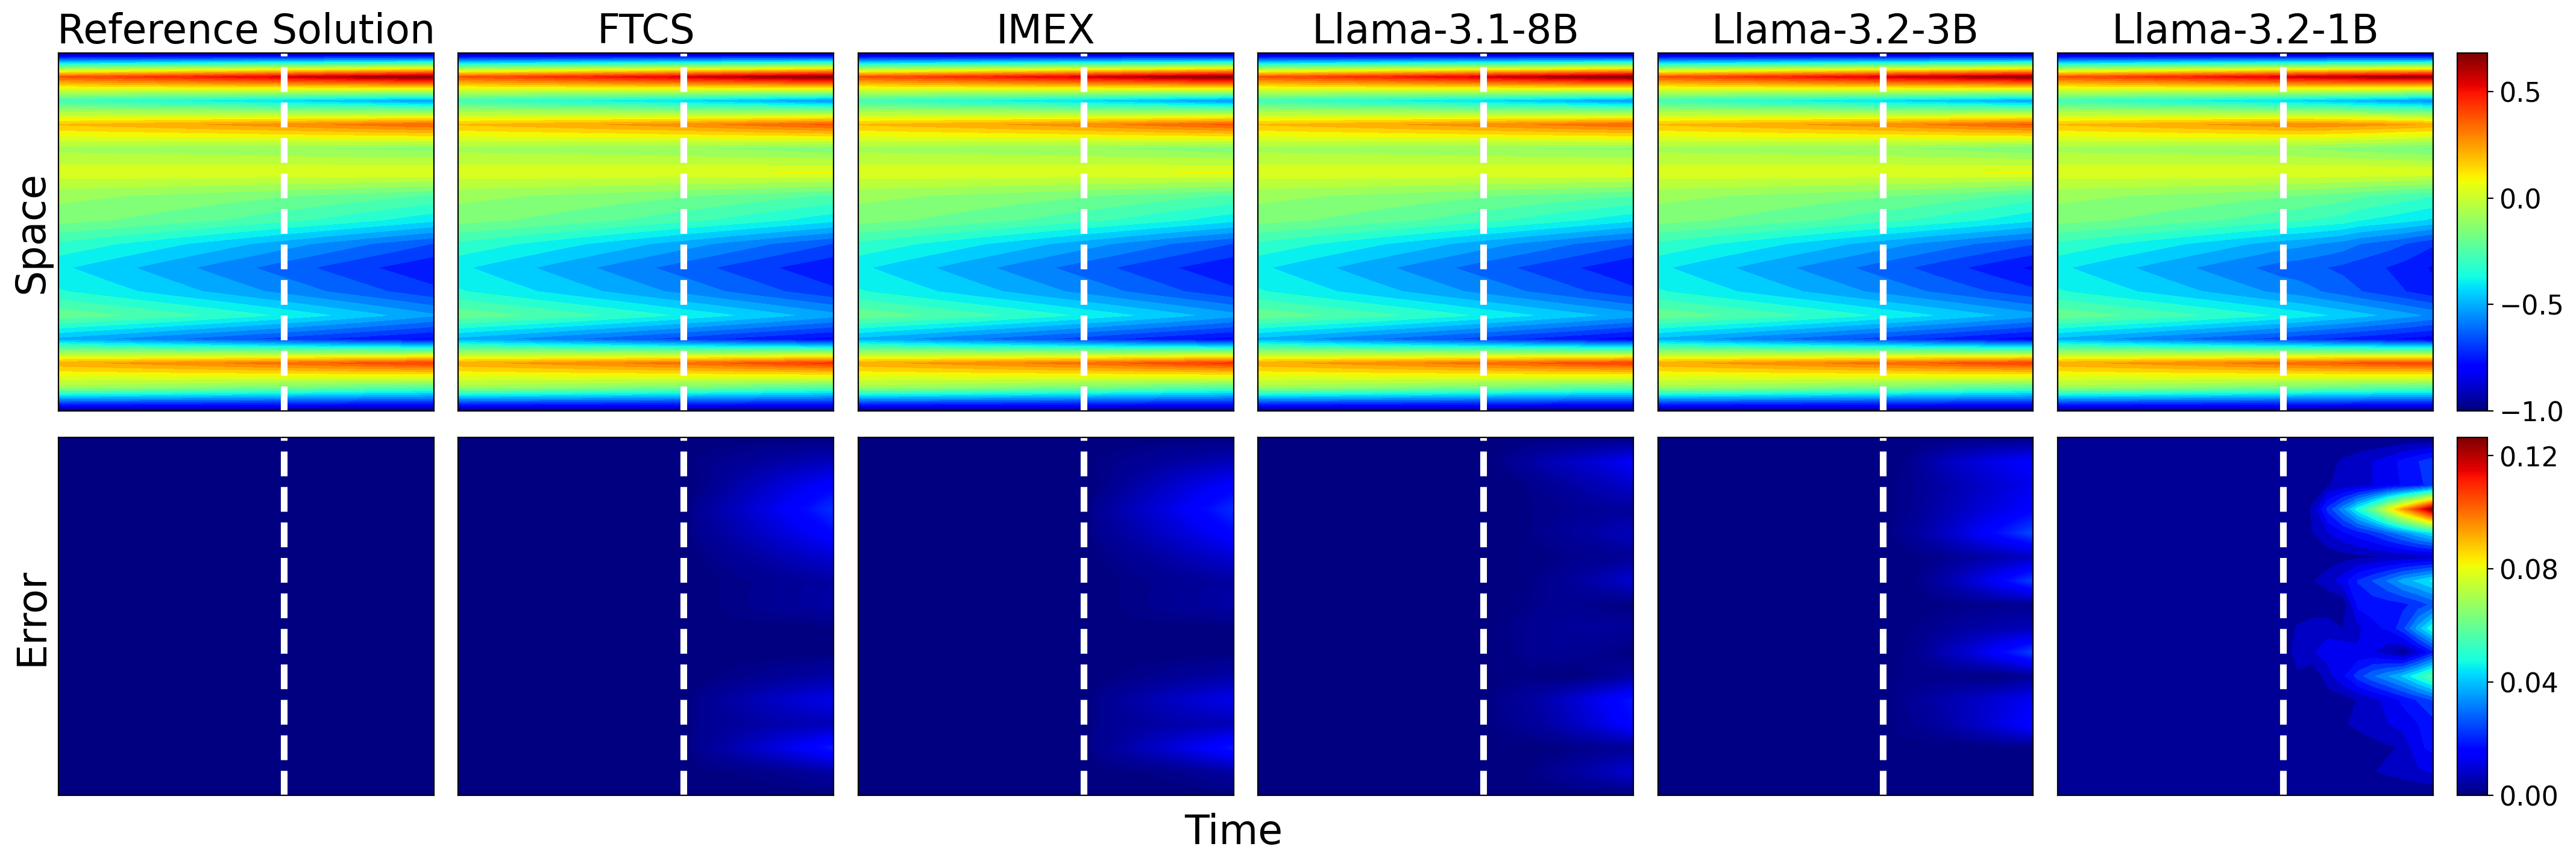

In [4]:
# Create hybrid solutions (first 16 steps exact, last 10 predicted)
u_llama_8b = u_exact.copy()
u_llama_8b[16:, :] = llm_predictions[:, 0, :]
u_llama_3b = u_exact.copy()
u_llama_3b[16:, :] = llm_predictions_3B[:, 0, :]
u_llama_1b = u_exact.copy()
u_llama_1b[16:, :] = llm_predictions_1B[:, 0, :]
u_ftcs = u_exact.copy()
u_ftcs[16:, :] = ftcs_predictions
u_imex = u_exact.copy()
u_imex[16:, :] = imex_predictions


def plot_solutions_with_errors():
    # Normalized domain parameters
    L = 1.0
    T = 1.0
    Nt_plus1, Nx = u_exact.shape
    x_full = np.linspace(-L/2, L/2, Nx+2)
    t = np.linspace(0, T, Nt_plus1)
    models = [u_exact, u_ftcs, u_imex, u_llama_8b, u_llama_3b, u_llama_1b]
    titles = ['Reference Solution', 'FTCS', 'IMEX', 
              'Llama-3.1-8B', 'Llama-3.2-3B', 'Llama-3.2-1B']
    fig = plt.figure(figsize=(26, 8), dpi=200)
    gs = fig.add_gridspec(2, 7, width_ratios=[1]*6 + [0.08],
                          height_ratios=[1, 1], 
                          wspace=0.075, hspace=0.075)
    vmin_sol = min(min(np.min(model) for model in models), -1.0)
    vmax_sol = max(np.max(model) for model in models)
    mappable_sol = plt.cm.ScalarMappable(cmap='jet')
    mappable_sol.set_clim(vmin_sol, vmax_sol)
    errors = []
    errors.append(np.zeros((Nt_plus1 - 16, Nx)))
    for i, model in enumerate(models[1:]):  # Skip reference solution
        error = np.abs(model[16:, :] - u_exact[16:, :])
        errors.append(error)
    vmax_err = max(np.max(error) for error in errors[1:])  # Skip the zero error
    mappable_err = plt.cm.ScalarMappable(cmap='jet')
    mappable_err.set_clim(0, vmax_err)
    for i, (model, title) in enumerate(zip(models, titles)):
        ax = fig.add_subplot(gs[0, i])
        # Add boundary conditions
        model_full = np.empty((Nt_plus1, Nx+2))
        model_full[:, 1:-1] = model
        model_full[:, [0, -1]] = -1.0
        ax.contourf(t, x_full, model_full.T, levels=30, cmap='jet',
                    vmin=vmin_sol, vmax=vmax_sol)
        ax.set_title(title, fontsize=24)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(t[15], color='white', linestyle='--', linewidth=4)
        if i == 0:
            ax.set_ylabel('Space', fontsize=24)
    
    for i, (error, title) in enumerate(zip(errors, titles)):
        ax = fig.add_subplot(gs[1, i])
        error_full = np.zeros((Nt_plus1, Nx+2))
        error_full[16:, 1:-1] = error
        ax.contourf(t, x_full, error_full.T, levels=30, cmap='jet',
                    vmin=0, vmax=vmax_err)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(t[15], color='white', linestyle='--', linewidth=4)
        if i == 0:
            ax.set_ylabel('Error', fontsize=24)
    fig.text(0.5, 0.06, 'Time', fontsize=24, ha='center')
    cax_sol = fig.add_subplot(gs[0, -1])
    cbar_sol = fig.colorbar(mappable_sol, cax=cax_sol)
    cbar_sol.ax.tick_params(labelsize=16)
    cbar_sol.locator = plt.MaxNLocator(nbins=4)
    cbar_sol.update_ticks()
    cax_err = fig.add_subplot(gs[1, -1])
    cbar_err = fig.colorbar(mappable_err, cax=cax_err)
    cbar_err.ax.tick_params(labelsize=16)
    cbar_err.locator = plt.MaxNLocator(nbins=4)
    cbar_err.update_ticks()

    plt.show()

plot_solutions_with_errors()

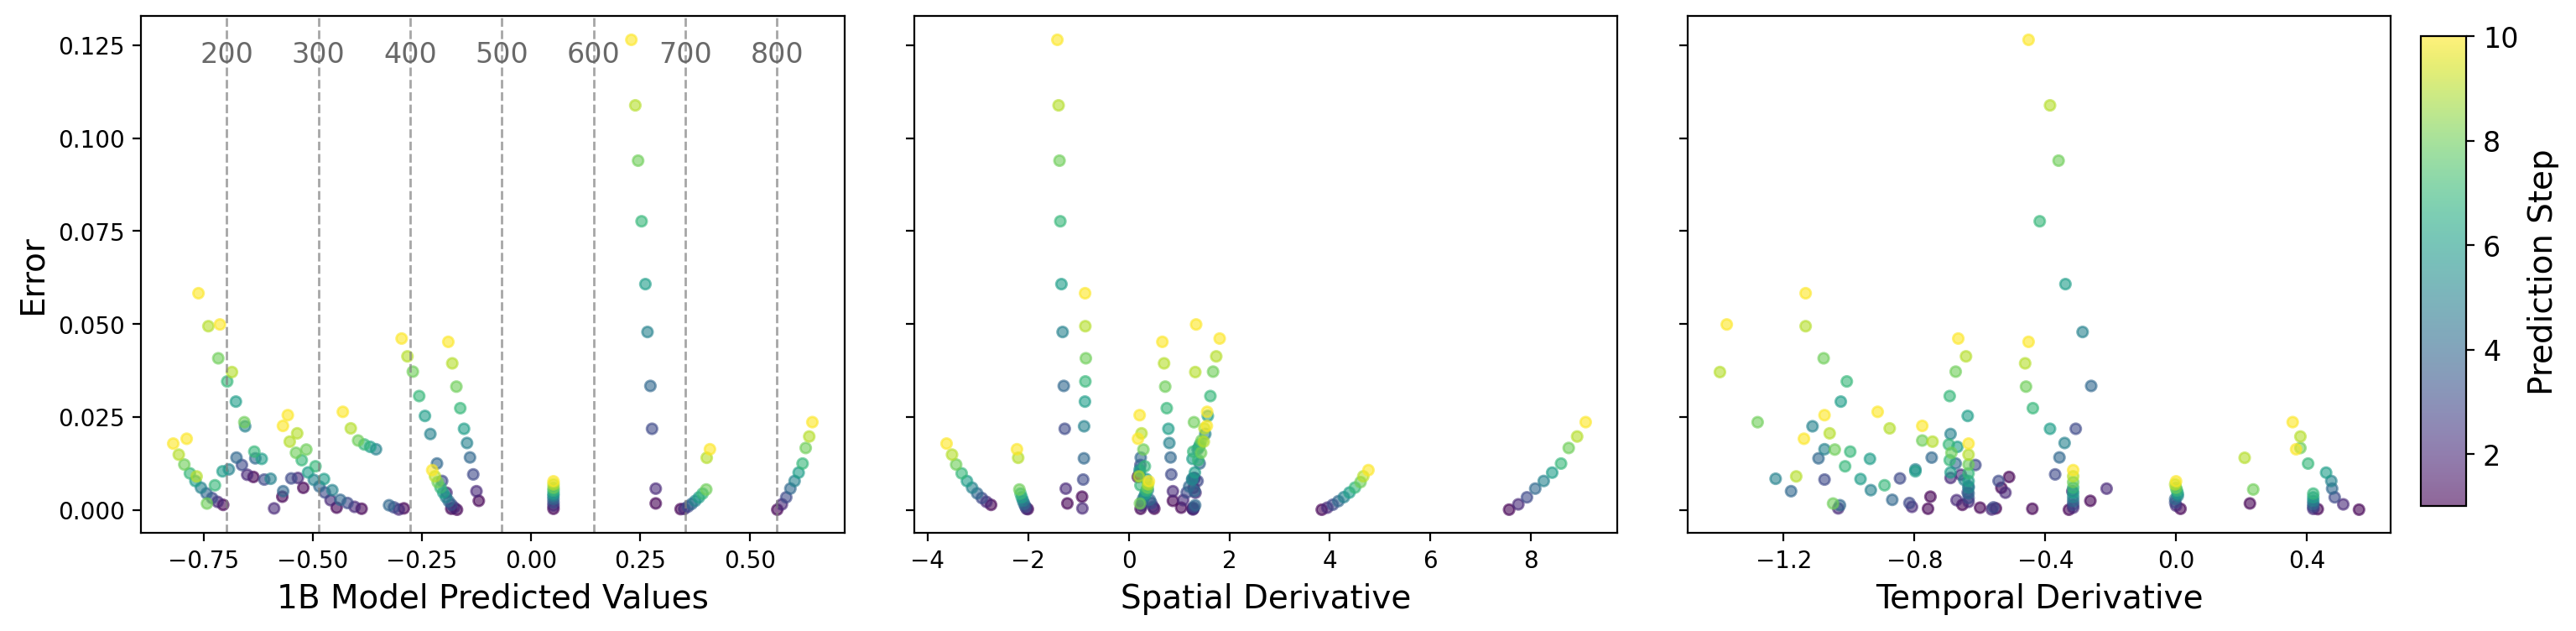

In [5]:
def compute_first_derivative(u, dx):
    """
    Compute first derivative using central differences
    """
    u_x = np.zeros_like(u)
    # Central differences for interior points
    u_x[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * dx)
    # Forward/backward differences for boundaries
    u_x[:, 0] = (u[:, 1] - u[:, 0]) / dx
    u_x[:, -1] = (u[:, -1] - u[:, -2]) / dx
    return u_x


def compute_temporal_derivative(u, dt):
    """
    Compute temporal derivative using central differences
    """
    u_t = np.zeros_like(u)
    # Central differences for interior time points
    u_t[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2 * dt)
    # Forward/backward differences for boundaries
    u_t[0, :] = (u[1, :] - u[0, :]) / dt
    u_t[-1, :] = (u[-1, :] - u[-2, :]) / dt
    return u_t


def unscale_value_from_150_850(scaled_val, v_min, v_max):
    """
    Maps an integer in [150, 850] back to a float in [v_min, v_max].
    """
    if np.isclose(v_min, v_max):
        return v_min
    ratio = (scaled_val - 150) / (850 - 150)
    return v_min + ratio * (v_max - v_min)


def analyze_1b_model_bias(u_exact, u_llama_1b):
    """
    Analyze the bias in the 1B model
    """
    # Spatial and temporal grid parameters
    L = 2.0
    T = 0.5
    Nx = 14
    Nt = 25
    dx = L / (Nx + 1)
    dt = T / Nt
    u_1b_pred = u_llama_1b[16:, :]
    u_exact_pred = u_exact[16:, :]
    u_x_1b = compute_first_derivative(u_llama_1b, dx)
    u_t_1b = compute_temporal_derivative(u_llama_1b, dt)
    # Extract derivatives for prediction region
    u_x_1b_pred = u_x_1b[16:, :]
    u_t_1b_pred = u_t_1b[16:, :]
    abs_error = np.abs(u_1b_pred - u_exact_pred)
    u_1b_pred_flat = u_1b_pred.flatten()
    u_x_1b_pred_flat = u_x_1b_pred.flatten()
    u_t_1b_pred_flat = u_t_1b_pred.flatten()
    abs_error_flat = abs_error.flatten()
    time_steps = np.repeat(np.arange(1, 11), Nx)
    v_min = u_exact.min()
    v_max = u_exact.max()
    
    # Calculate floating point values corresponding to 'nice' integer tokens
    nice_integers = [200, 300, 400, 500, 600, 700, 800]
    reference_values = [unscale_value_from_150_850(val, v_min, v_max) for val in nice_integers]
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), dpi=200, sharey=True)

    # Subplot 1: Error vs Numerical Values
    ax = axes[0]
    scatter1 = ax.scatter(u_1b_pred_flat, abs_error_flat, c=time_steps, s=20, alpha=0.6, cmap='viridis')
    # Add reference lines for 'nice' integers
    for ref_val, int_val in zip(reference_values, nice_integers):
        ax.axvline(ref_val, color='gray', linestyle='--', alpha=0.7, linewidth=1)
        ax.text(ref_val, ax.get_ylim()[1] * 0.95, str(int_val),  ha='center', va='top', fontsize=12, color='dimgray')
    ax.set_xlabel('1B Model Predicted Values', fontsize=14)
    ax.set_ylabel('Error', fontsize=14)
    
    # Subplot 2: Error vs Spatial Derivative
    ax = axes[1]
    scatter2 = ax.scatter(u_x_1b_pred_flat, abs_error_flat, c=time_steps, s=20, alpha=0.6, cmap='viridis')
    ax.set_xlabel('Spatial Derivative', fontsize=14)
    
    # Subplot 3: Error vs Temporal Derivative
    ax = axes[2]
    scatter3 = ax.scatter(u_t_1b_pred_flat, abs_error_flat,
                         c=time_steps, s=20, alpha=0.6, cmap='viridis')
    ax.set_xlabel('Temporal Derivative', fontsize=14)
    
    for ax in axes:
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=7))
        ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
        ax.tick_params(axis='both', labelsize=10)
    fig.subplots_adjust(right=0.87,wspace=0.1)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(scatter1, cax=cbar_ax)
    cbar.set_label('Prediction Step', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    plt.show()

analyze_1b_model_bias(u_exact, u_llama_1b)

In [6]:
def plot_error_analysis_loglog(llm_max_diffs, llm_rmses,
                                llm_max_diffs_3B, llm_rmses_3B,
                                llm_max_diffs_1B, llm_rmses_1B,
                                ci_lower_max_diffs, ci_upper_max_diffs, ci_lower_rmses, ci_upper_rmses,
                                ci_lower_max_diffs_3B, ci_upper_max_diffs_3B, ci_lower_rmses_3B, ci_upper_rmses_3B,
                                ci_lower_max_diffs_1B, ci_upper_max_diffs_1B, ci_lower_rmses_1B, ci_upper_rmses_1B,
                                ftcs_max_diff, ftcs_rmse, imex_max_diff, imex_rmse,
                                baseline_max_error, baseline_rmse_error, reference_index):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5.5), dpi=200)
    steps_array = np.arange(1, len(llm_max_diffs) + 1)
    colors = [
        "#E69F00",  # Llama-3.1-8B
        "#56B4E9",  # Llama-3.2-3B
        "#009E73",  # Llama-3.2-1B
        "#CC79A7",  # FTCS
        "#D55E00",  # IMEX
        "#999999",  # Quant floor
    ]
    
    power_law_color = "black"
    linewidth = 2
    
    # Compute power law reference lines O(n)
    max_diff_reference = llm_max_diffs[reference_index]
    rmse_reference = llm_rmses[reference_index]
    power_law_max_diff = [max_diff_reference * n for n in steps_array]
    power_law_rmse = [rmse_reference * n for n in steps_array]
    
    # Plot Maximum Difference (left subplot)
    ax1.loglog(steps_array, llm_max_diffs, 'o-', label='Llama-3.1-8B',
               color=colors[0], markersize=8, linewidth=linewidth, zorder=5)
    ax1.fill_between(steps_array, ci_lower_max_diffs, ci_upper_max_diffs,
                     alpha=0.3, color=colors[0])
    ax1.loglog(steps_array, llm_max_diffs_3B, 'o--', label='Llama-3.2-3B',
               color=colors[1], markersize=8, linewidth=linewidth)
    ax1.fill_between(steps_array, ci_lower_max_diffs_3B, ci_upper_max_diffs_3B,
                     alpha=0.3, color=colors[1])
    ax1.loglog(steps_array, llm_max_diffs_1B, 'o-.', label='Llama-3.2-1B',
               color=colors[2], markersize=8, linewidth=linewidth)
    ax1.fill_between(steps_array, ci_lower_max_diffs_1B, ci_upper_max_diffs_1B,
                     alpha=0.3, color=colors[2])
    ax1.loglog(steps_array[:len(ftcs_max_diff)], ftcs_max_diff, 'x:', markeredgewidth=2,
               label='Numerical Solver (FTCS)', color=colors[3], markersize=12, linewidth=linewidth)
    ax1.loglog(steps_array[:len(imex_max_diff)], imex_max_diff, '^-',
               label='Numerical Solver (IMEX)', color=colors[4], markersize=8, linewidth=linewidth)
    
    # Add O(n) reference line and annotation
    ax1.loglog(steps_array[3:11], power_law_max_diff[3:11], '--',
               linewidth=linewidth, color=power_law_color)
    ax1.annotate(r'$\mathcal{O}(n)$',
                 xy=(steps_array[reference_index-2], power_law_max_diff[reference_index]),
                 xytext=(0, 0), textcoords='offset points',
                 color=power_law_color, fontsize=16, rotation=10)
    ax1.loglog(steps_array, baseline_max_errors_prediction, 's--', color=colors[5],
                label='Quant Floor', markersize=6, linewidth=linewidth)
    ax1.set_xlabel("LLM Output Length ($N_{\\text{Tokens}}$)", fontsize=14)
    ax1.set_ylabel("MaxAE", fontsize=14)
    
    # Plot RMSE (right subplot)
    ax2.loglog(steps_array, llm_rmses, 'o-', label='Llama-3.1-8B',
               color=colors[0], markersize=8, linewidth=linewidth, zorder=5)
    ax2.fill_between(steps_array, ci_lower_rmses, ci_upper_rmses,
                     alpha=0.3, color=colors[0])
    ax2.loglog(steps_array, llm_rmses_3B, 'o--', label='Llama-3.2-3B',
               color=colors[1], markersize=8, linewidth=linewidth)
    ax2.fill_between(steps_array, ci_lower_rmses_3B, ci_upper_rmses_3B,
                     alpha=0.3, color=colors[1])
    ax2.loglog(steps_array, llm_rmses_1B, 'o-.', label='Llama-3.2-1B',
               color=colors[2], markersize=8, linewidth=linewidth)
    ax2.fill_between(steps_array, ci_lower_rmses_1B, ci_upper_rmses_1B,
                     alpha=0.3, color=colors[2])
    ax2.loglog(steps_array[:len(ftcs_rmse)], ftcs_rmse, 'x:', markeredgewidth=2,
               label='Numerical Solver (FTCS)', color=colors[3], markersize=12, linewidth=linewidth)
    ax2.loglog(steps_array[:len(imex_rmse)], imex_rmse, '^-',
               label='Numerical Solver (IMEX)', color=colors[4], markersize=8, linewidth=linewidth)
    
    # Add O(n) reference line and annotation
    ax2.loglog(steps_array[3:11], power_law_rmse[3:11], '--',
               color=power_law_color, linewidth=linewidth)
    ax2.annotate(r'$\mathcal{O}(n)$',
                 xy=(steps_array[reference_index-2], power_law_rmse[reference_index]),
                 xytext=(0, 0), textcoords='offset points',
                 color=power_law_color, fontsize=16, rotation=10)
    ax2.loglog(steps_array, baseline_rmse_errors_prediction, 's--', color=colors[5],
                label='Quant Floor', markersize=6, linewidth=linewidth)
    ax2.set_xlabel("LLM Output Length ($N_{\\text{Tokens}}$)", fontsize=14)
    ax2.set_ylabel("RMSE", fontsize=14)

    selected_positions = [1, 2, 3, 5, 7, 10]
    selected_tick_positions = [pos for pos in steps_array if pos in selected_positions]
    token_tick_labels = [str(int(pos * 27)) for pos in selected_tick_positions]
    ax1.set_xticks(selected_tick_positions)
    ax1.set_xticklabels(token_tick_labels)
    ax2.set_xticks(selected_tick_positions)
    ax2.set_xticklabels(token_tick_labels)
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)
    ax1_top = ax1.twiny()
    ax2_top = ax2.twiny()
    ax1_top.set_xlim(ax1.get_xlim())
    ax2_top.set_xlim(ax2.get_xlim())
    ax1_top.set_xscale('log')
    ax2_top.set_xscale('log')
    ax1_top.set_xticks(list(steps_array))
    ax1_top.set_xticklabels([str(int(pos)) for pos in steps_array])
    ax2_top.set_xticks(list(steps_array))
    ax2_top.set_xticklabels([str(int(pos)) for pos in steps_array])
    ax1_top.set_xlabel("Prediction Steps ($n$)", fontsize=14, color='darkred')
    ax2_top.set_xlabel("Prediction Steps ($n$)", fontsize=14, color='darkred')
    ax1_top.tick_params(axis='x', which='major', labelsize=13, colors='darkred')
    ax2_top.tick_params(axis='x', which='major', labelsize=13, colors='darkred')
    ax2_top.tick_params(axis='x', which='major', labelsize=13, colors='darkred')
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=14, handlelength=1.8,
               bbox_to_anchor=(0.525, 0.0), columnspacing=1)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.18, top=0.9)
    
    return fig, (ax1, ax2)

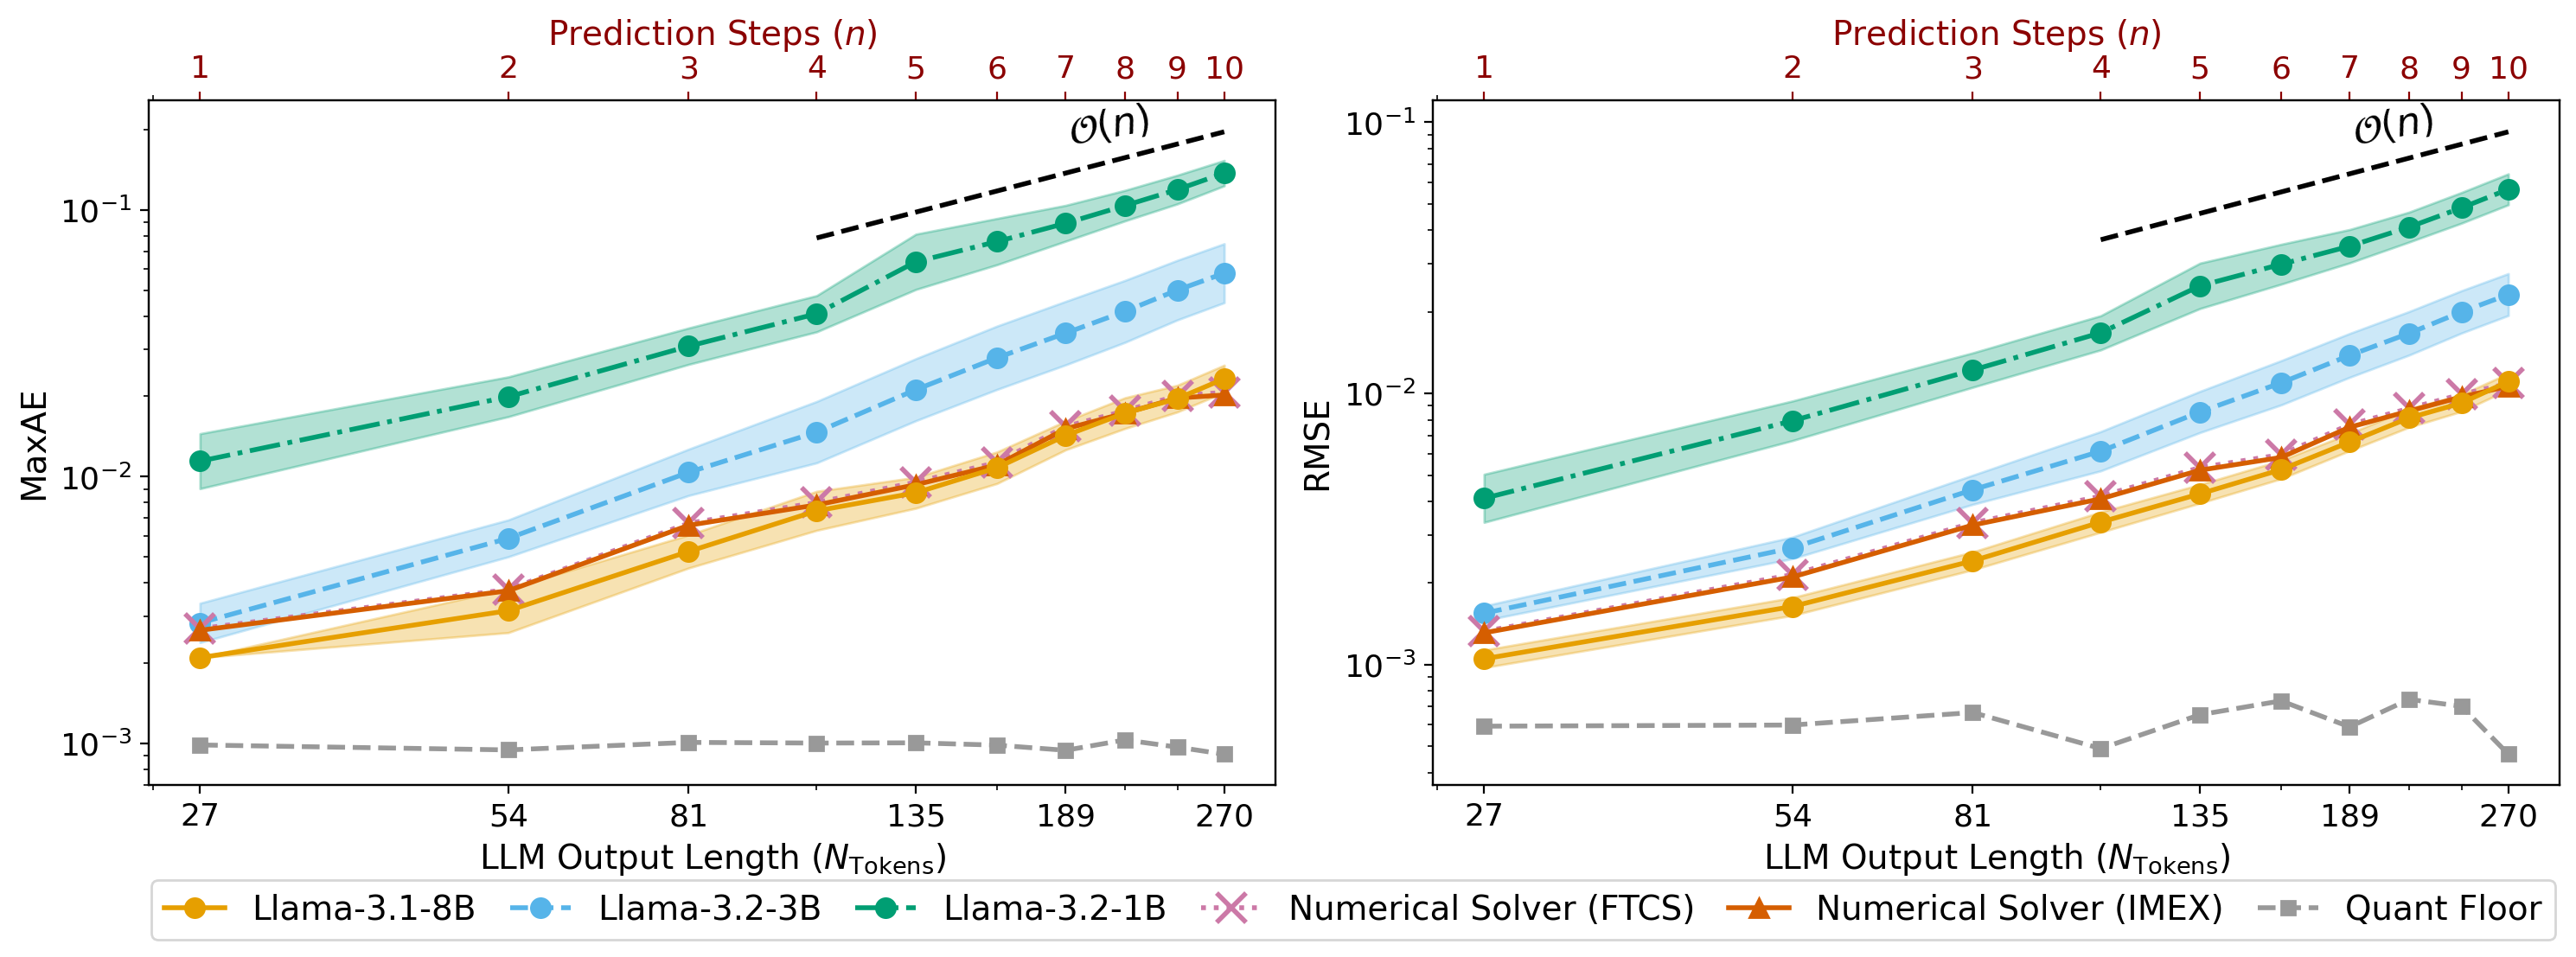

In [7]:
fig, (ax1, ax2) = plot_error_analysis_loglog(
    llm_max_diffs, llm_rmses,
    llm_max_diffs_3B, llm_rmses_3B,
    llm_max_diffs_1B, llm_rmses_1B,
    ci_lower_max_diffs, ci_upper_max_diffs, ci_lower_rmses, ci_upper_rmses,
    ci_lower_max_diffs_3B, ci_upper_max_diffs_3B, ci_lower_rmses_3B, ci_upper_rmses_3B,
    ci_lower_max_diffs_1B, ci_upper_max_diffs_1B, ci_lower_rmses_1B, ci_upper_rmses_1B, 
    ftcs_max_diff, ftcs_rmse, imex_max_diff, imex_rmse,
    baseline_max_errors_prediction, baseline_rmse_errors_prediction, reference_index=8
)
plt.show()